# Testing RNN #

In [1]:
from tools.numerical_gradient import *
from models.layers import *
from models.networks.vanilla_rnn import *
from models.solver.solver import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
import nltk
import re
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
#############
# Constants #
#############

word_sequence_dest = "word_sequence.hdf5"
word_mapping_dest = "word_map.pkl"
idx_mapping_dest = "idx_map.pkl"
word_dataset_dest = "word_dataset.hdf5"
cache_model_dest = "cache_model.pkl"
seq_len = 5

delims = ' |\t|\r\n'

In [3]:
# Read in the data of X_all
with h5py.File(word_dataset_dest, 'r') as f:
    bible = f["bible"][:]
with open(idx_mapping_dest, 'r') as f:
    idx_mapping = pickle.load(f)
max_idx = np.max(bible)

In [4]:
bible = np.array([[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],
                  [1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0],[1,0,1,0,1],[0,1,0,1,0]])
N,T = bible.shape
num_samples = 8
num_words = 2 #max_idx+1
time_dim = 2
hidden_dim = 100
word_vec_dim = 100

rnn = VanillaRNN(num_samples, num_words, time_dim, hidden_dim, word_vec_dim)

In [5]:
print bible.shape, N, T

(160, 5) 160 5


In [6]:
solver = Solver({"learning_rate" : 1e-4, "type" : "momentum",
                 "mu" : 0.90})
                 #"beta1" : 0.9, "beta2" : 0.99}) # adagrad/adam can sustain higher learning rates

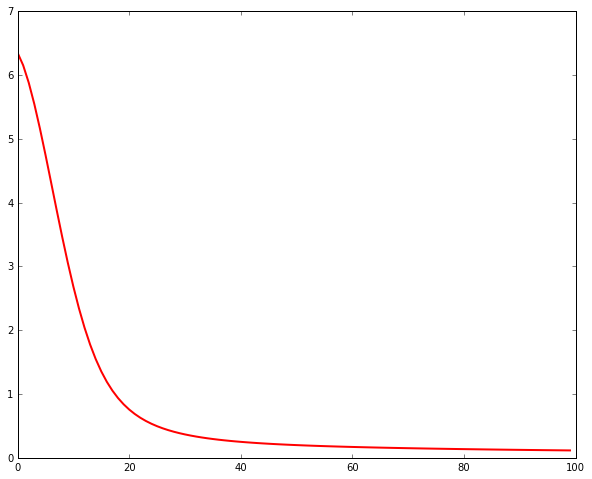

In [9]:
c

[-0.01624876  0.01624876]


# Let's use the best model we have and see what happens! #

In [8]:
# TODO: Save the best model
print solver.min_loss
l = solver.min_loss_model
# [p("words"), dwords], 
# [p("W_xh"), dW_xh], 
# [p("W_hh"), dW_hh],
# [p("W_hy"), dW_hy],
# [p("b_affine"), db_affine],
# [p("b_rnn"), db_rnn]
with h5py.File(cache_model_dest, 'w') as f:
    f.create_dataset('words', data=l[0][0])
    f.create_dataset("W_xh", data=l[1][0])
    f.create_dataset("W_hh", data=l[2][0])
    f.create_dataset("W_hy", data=l[3][0])
    f.create_dataset("b_affine", data=l[4][0])
    f.create_dataset("b_rnn", data=l[5][0])

0.660657215412


IndexError: list index out of range

In [11]:
seq = rnn.predict(1, seq_len=10) # We fed in "God" as the first token.
print seq
words = [idx_mapping[i] for i in seq]

[[[ 0.92406599  0.07593401]]]
0


TypeError: 'int' object is not iterable

In [19]:
print words

NameError: name 'words' is not defined

In [15]:
print bible[curPtr:curPtr+num_samples, :]
print bible[curPtr+1:curPtr+num_samples+1, :]

[[11032  2070 22371 29900 15827 15939]
 [ 2070 22371 29900 15827 15939 11032]
 [22371 29900 15827 15939 11032 11575]
 [29900 15827 15939 11032 11575 15939]
 [15827 15939 11032 11575 15939 11032]
 [15939 11032 11575 15939 11032 17191]
 [11032 11575 15939 11032 17191 25010]
 [11575 15939 11032 17191 25010 13170]
 [15939 11032 17191 25010 13170 13174]
 [11032 17191 25010 13170 13174 11032]
 [17191 25010 13170 13174 11032 25318]
 [25010 13170 13174 11032 25318 15939]
 [13170 13174 11032 25318 15939 11032]
 [13174 11032 25318 15939 11032  2060]
 [11032 25318 15939 11032  2060 20233]
 [25318 15939 11032  2060 20233 14936]
 [15939 11032  2060 20233 14936  8877]
 [11032  2060 20233 14936  8877  5874]
 [ 2060 20233 14936  8877  5874 25474]
 [20233 14936  8877  5874 25474  2739]
 [14936  8877  5874 25474  2739 21019]
 [ 8877  5874 25474  2739 21019 15939]
 [ 5874 25474  2739 21019 15939 26384]
 [25474  2739 21019 15939 26384 12595]
 [ 2739 21019 15939 26384 12595 25474]
 [21019 15939 26384 12595